In [ ]:
# Import the required packages
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

import matplotlib.pyplot as plt
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.preprocessing.image import *
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPool2D, Dropout
# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

we will be using [spela](https://github.com/kongkip/spela) a package used to compute speech features 
e.g spectrograms and melspectrograms implemented using tf.keras to take advantage of GPU during computations

In [ ]:
# a package to compute speech features, implemented using tf.keras
try:
    from spela.spectrogram import Spectrogram 
    from spela.melspectrogram import Melspectrogram
except:
    !pip install spela
    from spela.spectrogram import Spectrogram 
    from spela.melspectrogram import Melspectrogram

In [ ]:
# disable eager execution, my model couldn't train well while on eager mode
tf.compat.v1.disable_eager_execution()

In [ ]:
# Get the data directories
data_dir = "/content/drive/MyDrive/16000_pcm_speeches"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import shutil
# shutil.unpack_archive("/content/drive/MyDrive/archive.zip","/content/drive/MyDrive/")

In [ ]:
classes = ['Nelson_Mandela', 'Magaret_Tarcher','Benjamin_Netanyau','Jens_Stoltenberg', 'Julia_Gillard'] 

In [ ]:
# inspect the folders inside the dataset
os.listdir(data_dir)

['Benjamin_Netanyau',
 'Jens_Stoltenberg',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela',
 '_background_noise_',
 'other',
 'tf_Wav_reader.py']

In [ ]:
# for now we are concerned with the four speakers
# lets get as a sample data from one of the speakers
nelson_madela = [item for item in os.listdir('/content/drive/MyDrive/16000_pcm_speeches/Nelson_Mandela')]
nelson_madela[:10]

['1448.wav',
 '1449.wav',
 '145.wav',
 '1450.wav',
 '1451.wav',
 '1452.wav',
 '1453.wav',
 '1454.wav',
 '1455.wav',
 '1456.wav']

In [ ]:
# lets create a function that takes in a raw wavfile and computes a spectrogram then plots it
def compute_spectrogram_melspectrogram_and_plot(wav_dir, compute_type):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
        wav_decoder, feed_dict={
            wav_filename_placeholder: wav_dir
        }).audio.flatten()
        sess.close()
    # audio has a sample rate of 16000 and the produced wav has a shape of (16000, 1)
    # reshape to (1, 1600)
    wav = wav_data.reshape(1, 16000)
    wav_new = wav[np.newaxis, :] # introduce a new axis to have a shape of (1, 1, 16000)
    height = wav_new.shape[1]
    width = wav_new.shape[2]
    # create a model to compute spectrogram
    model = tf.keras.Sequential() 
    if compute_type == "spectrogram":
        model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=(height, width),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
    elif compute_type == "melspectrogram":
        model.add(Melspectrogram(sr=16000, n_mels=128,n_dft=512, n_hop=256,
                            input_shape=(height, width), return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))
   
    # producing a spectrogram/melspectrogram from the model
    pred = model.predict(x=wav_new)

    if tf.keras.backend.image_data_format() == "channel_first":
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]

    # show the spectrogram/melspectrogram
    librosa.display.specshow(result, y_axis='linear', sr=16000)

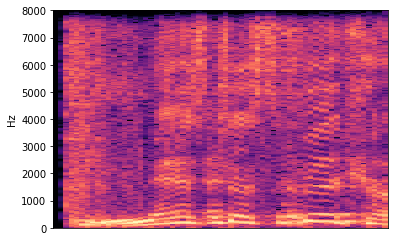

In [ ]:
compute_spectrogram_melspectrogram_and_plot('/content/drive/MyDrive/16000_pcm_speeches/Nelson_Mandela/0.wav', "spectrogram")

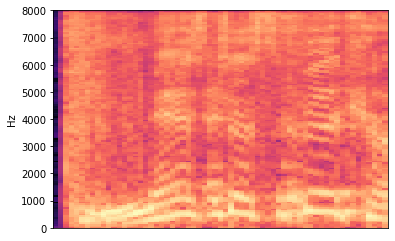

In [ ]:
compute_spectrogram_melspectrogram_and_plot('/content/drive/MyDrive/16000_pcm_speeches/Nelson_Mandela/0.wav', "melspectrogram")

# Process training dataset

In [ ]:
# get wav paths
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [ ]:
nelson_mandela_paths = get_wav_paths("/Nelson_Mandela")
margaret_thatcher_paths = get_wav_paths("/Magaret_Tarcher")
benjamin_netanyau_paths = get_wav_paths("/Benjamin_Netanyau")
jens_stoltenberg_paths = get_wav_paths( '/Jens_Stoltenberg')
julia_gillard_paths = get_wav_paths("/Julia_Gillard")

In [ ]:
# load the data
def load_wav(wav_path, speaker):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_path = data_dir +speaker + "/"+ wav_path
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
            wav_decoder, feed_dict={
                wav_filename_placeholder: wav_path
            }).audio.flatten().reshape((1, 16000))
        sess.close()
    return wav_data
    

In [ ]:
# create training data
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        wavs.append(wav)
        labels.append(label)
    return wavs, labels


In [ ]:
nelson_mandela_wavs, nelson_mandela_labels = generate_training_data(nelson_mandela_paths, "/Nelson_Mandela", 0) 
margaret_thatcher_wavs, margaret_thatcher_labels = generate_training_data(margaret_thatcher_paths, "/Magaret_Tarcher", 1) 
benjamin_netanyau_wavs, benjamin_netanyau_labels = generate_training_data(benjamin_netanyau_paths, "/Benjamin_Netanyau", 2) 
jens_stoltenberg_wavs, jens_stoltenberg_labels = generate_training_data(jens_stoltenberg_paths, "/Jens_Stoltenberg", 3) 
julia_gillard_wavs, julia_gillard_labels = generate_training_data(julia_gillard_paths, "/Julia_Gillard", 4) 

100%|██████████| 1501/1501 [12:25<00:00,  2.01it/s]


In [ ]:
# remove the extra wav for Julia Gillard
julia_gillard_labels = julia_gillard_labels[1:]
julia_gillard_wavs = julia_gillard_wavs[1:]

In [ ]:
all_wavs = nelson_mandela_wavs + margaret_thatcher_wavs + benjamin_netanyau_wavs + jens_stoltenberg_wavs + julia_gillard_wavs
all_labels = nelson_mandela_labels + margaret_thatcher_labels + benjamin_netanyau_labels + jens_stoltenberg_labels + julia_gillard_labels

In [ ]:
# split the dataset into trainin and testing set\
train_wavs, test_wavs, train_labels, test_labels = train_test_split(all_wavs, all_labels, test_size=0.2)

In [ ]:
train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)

In [ ]:
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [ ]:
np.save('/content/drive/MyDrive/16000_pcm_speeches/train_x.npy',train_x)
np.save('/content/drive/MyDrive/16000_pcm_speeches/train_y.npy',train_y)
np.save('/content/drive/MyDrive/16000_pcm_speeches/test_x.npy',test_x)
np.save('/content/drive/MyDrive/16000_pcm_speeches/test_y.npy',test_y)

In [ ]:
train_x, train_y = np.load('/content/drive/MyDrive/16000_pcm_speeches/train_x.npy'), np.load('/content/drive/MyDrive/16000_pcm_speeches/train_y.npy')
test_x, test_y = np.load('/content/drive/MyDrive/16000_pcm_speeches/test_x.npy'), np.load('/content/drive/MyDrive/16000_pcm_speeches/test_y.npy')

# Train with 5 first labels Fashion Mnist trained model

In [ ]:
model_trained = tf.keras.models.load_model("/content/drive/MyDrive/u5")
for layer in model_trained.layers[:20]:
   layer.trainable =False

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam ,RMSprop
import os 

Learning_rate = 2.0679516672208156e-30

optimizer = Adam(lr=Learning_rate)
 
model_trained.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-100)

batch_size = 45
checkpoint_path = "/content/drive/MyDrive/16000_pcm_speeches"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_accuracy',mode='max',
                                                               save_best_only=True)

In [ ]:
Y = np.array([np.where(r==1)[0][0] for r in train_y])


In [ ]:
train_x.shape

(5999, 1, 16000)

In [ ]:
import os
import shutil
import  joblib
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm

In [ ]:
class params:
    """
    Parameters used for the audio data
    """
    sr = 16000

    # Melspectrogram
    n_mels = 28
    fmin = 15
    fmax = sr // 2  # Shannon theorem

In [ ]:
def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
    """
    melspec = lb.feature.melspectrogram( 
        y, sr=params.sr, hop_length=590, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax,n_fft=2000,
    )

    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

Convert wav signal to mel_spectrograms

In [ ]:
mel_train_x = []
for i in range(len(train_x)):
  mel_train_x.append(compute_melspec(train_x[i].reshape(16000), params))
mel_test_x = []
for i in range(len(test_x)):
  mel_test_x.append(compute_melspec(test_x[i].reshape(16000), params))
  

In [ ]:
mel_train_x = np.array(mel_train_x)
mel_train_x.shape
mel_test_x = np.array(mel_test_x)
mel_test_x.shape

(1500, 28, 28)

In [ ]:
history3 = model_trained.fit(x=mel_train_x, y= Y, epochs = 100, validation_split = 0.10, shuffle = True,
                     batch_size = batch_size, verbose = 1, steps_per_epoch= train_x.shape[0] // batch_size,callbacks=[checkpoint,learning_rate_reduction])
model_trained.save("/content/drive/MyDrive/16000_pcm_speeches/") # saving the model

np.save('/content/drive/MyDrive/16000_pcm_speeches/history3.npy',history3.history)


Epoch 1/100
66/66 [==============================] - 2s 10ms/step - loss: 0.2537 - accuracy: 0.9166 - val_loss: 0.2140 - val_accuracy: 0.9433
INFO:tensorflow:Assets written to: /content/drive/MyDrive/16000_pcm_speeches/assets
Epoch 2/100
66/66 [==============================] - 0s 5ms/step - loss: 0.2505 - accuracy: 0.9090 - val_loss: 0.2128 - val_accuracy: 0.9433
Epoch 3/100
66/66 [==============================] - 0s 5ms/step - loss: 0.2542 - accuracy: 0.9079 - val_loss: 0.2132 - val_accuracy: 0.9433
Epoch 4/100
66/66 [==============================] - 0s 5ms/step - loss: 0.2473 - accuracy: 0.9153 - val_loss: 0.2145 - val_accuracy: 0.9433

Epoch 00004: ReduceLROnPlateau reducing learning rate to 5.551115487763799e-22.
Epoch 5/100
66/66 [==============================] - 0s 5ms/step - loss: 0.2571 - accuracy: 0.9086 - val_loss: 0.2135 - val_accuracy: 0.9433
Epoch 6/100
66/66 [==============================] - 0s 5ms/step - loss: 0.2641 - accuracy: 0.9051 - val_loss: 0.2125 - val_accur

History 1+2

In [ ]:
def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

In [ ]:
history1 = np.load("/content/drive/MyDrive/16000_pcm_speeches/history1.npy",allow_pickle=True).item()
history2 = np.load("/content/drive/MyDrive/16000_pcm_speeches/history2.npy",allow_pickle=True).item()
history1_2 =  appendHist (history1, history2)
np.save("/content/drive/MyDrive/16000_pcm_speeches/history1_2.npy",history1_2)
history1_2 = np.load("/content/drive/MyDrive/16000_pcm_speeches/history1_2.npy",allow_pickle=True).item()

In [ ]:
history1_2 = np.load("/content/drive/MyDrive/16000_pcm_speeches/history1_2.npy",allow_pickle=True).item()
history3 = np.load("/content/drive/MyDrive/16000_pcm_speeches/history3.npy",allow_pickle=True).item()
history1_3 =  appendHist (history1_2, history3)
np.save("/content/drive/MyDrive/16000_pcm_speeches/history1_3.npy",history1_3)
history1_3 = np.load("/content/drive/MyDrive/16000_pcm_speeches/history1_3.npy",allow_pickle=True).item()

Visualizations

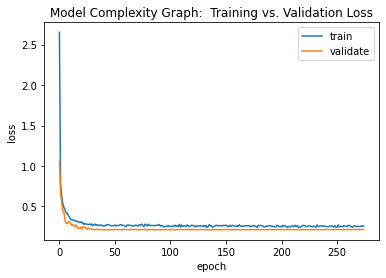

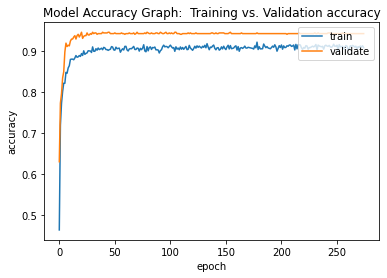

In [ ]:

plt.figure(1)
plt.plot(history1_3['loss'])
plt.plot(history1_3['val_loss'])
plt.title('Model Complexity Graph:  Training vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()
plt.figure(2)
plt.plot(history1_3['accuracy'])
plt.plot(history1_3['val_accuracy'])
plt.title('Model Accuracy Graph:  Training vs. Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

Evaluate with test data 


In [ ]:
Ytest = np.array([np.where(r==1)[0][0] for r in test_y])

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/16000_pcm_speeches")
score = model.evaluate(mel_test_x, Ytest, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

47/47 [==============================] - 0s 3ms/step - loss: 0.2552 - accuracy: 0.9193
Test loss: 0.2552048861980438
Test accuracy: 0.9193333387374878


Add trained fashion Mnist layers 

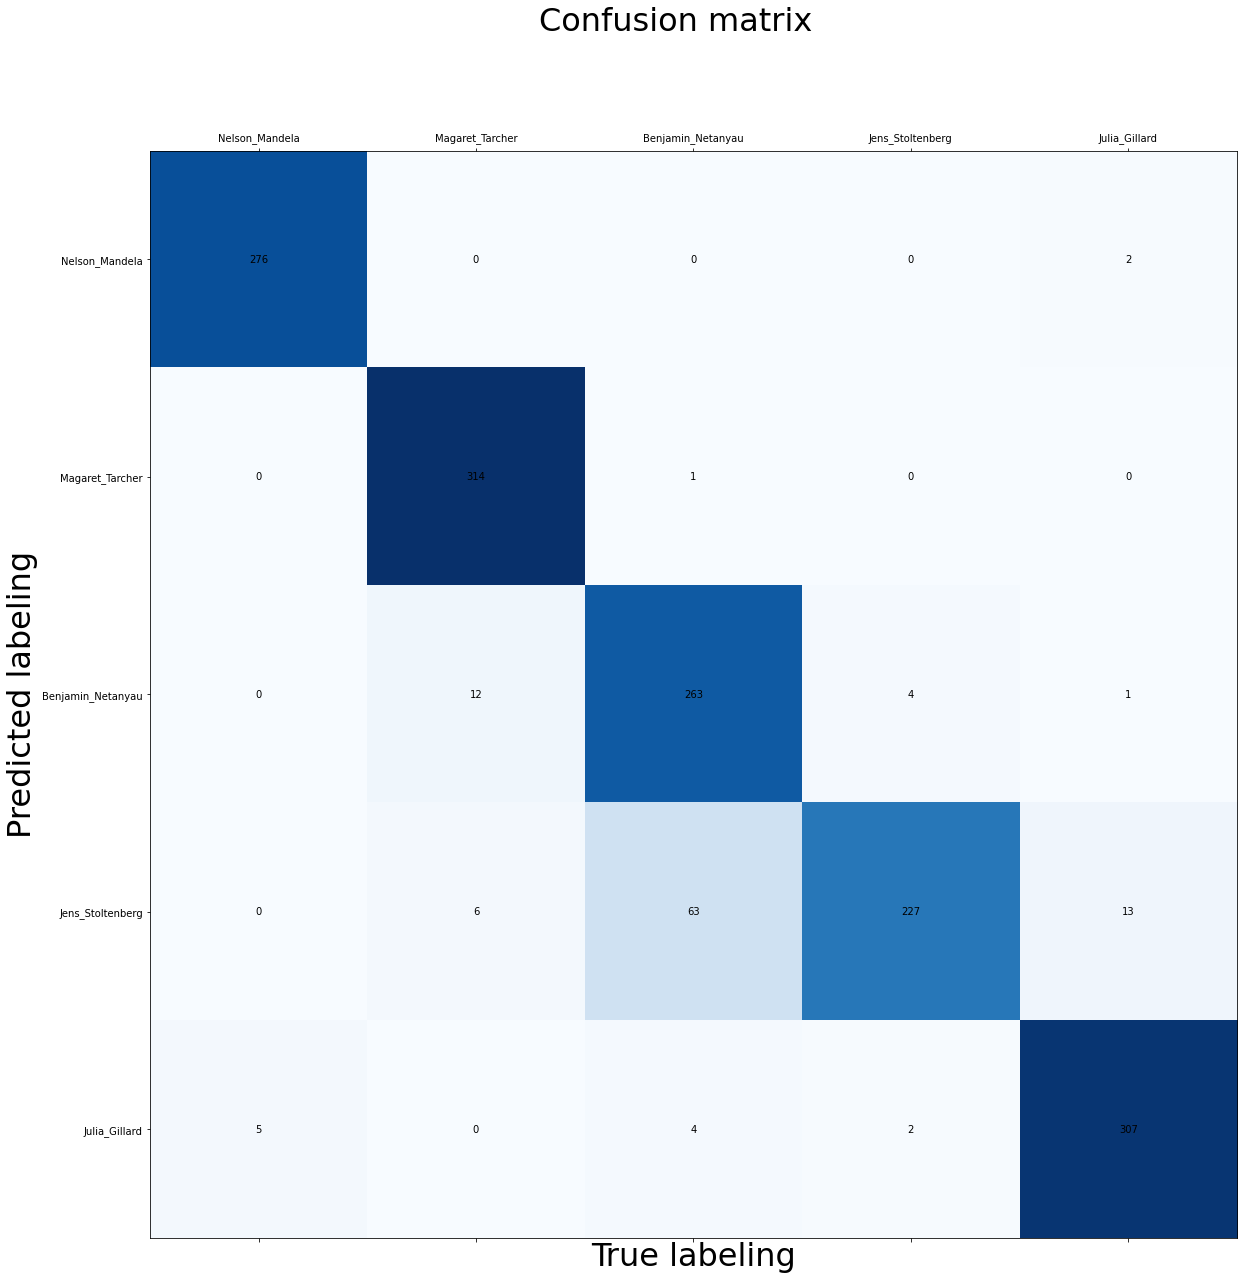

In [ ]:
from sklearn.metrics import confusion_matrix

y_vecs = model_trained.predict(mel_test_x)
y_pred = np.argmax(y_vecs, axis=1)
y_true = Ytest
cm = confusion_matrix(y_true, y_pred)
# print(cm)

# plt.imshow(cm, cmap = 'ocean')
# plt.colorbar

min_val, max_val = 0, 15

# intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(cm, cmap=plt.cm.Blues)
# ax.matshow(cm, cmap=plt.cm.magma_r)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

for i in range(5):
    for j in range(5):
        c = cm[j,i]
        ax.text(i, j, str(c), va='center', ha='center')


plt.xticks(range(5))
plt.yticks(range(5))
plt.suptitle('Confusion matrix',size = 32)
plt.xlabel('True labeling',size = 32)
plt.ylabel('Predicted labeling',size = 32)
plt.rcParams.update({'font.size': 28})

Train with the second 5 Fashion Mnist trained model

In [ ]:
model_trained = tf.keras.models.load_model("/content/drive/MyDrive/o5")
for layer in model_trained.layers[:20]:
   layer.trainable =False

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam ,RMSprop, Adagrad
import os 

Learning_rate = 7.006492321624085e-46

optimizer = Adagrad(lr=Learning_rate)
 
model_trained.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=1e-100)

batch_size = 64
checkpoint_path = "/content/drive/MyDrive/16000_pcm_speeches/o5model/"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_accuracy',mode='max',
                                                               save_best_only=True)

In [ ]:
history5 = model_trained.fit(x=mel_train_x, y= Y, epochs = 100, validation_split = 0.10, shuffle = True,
                     batch_size = batch_size, verbose = 1, steps_per_epoch= train_x.shape[0] // batch_size,callbacks=[checkpoint,learning_rate_reduction])
model_trained.save("/content/drive/MyDrive/16000_pcm_speeches/o5model") # saving the model

np.save('/content/drive/MyDrive/16000_pcm_speeches/o5model/history5.npy',history5.history)


Epoch 1/100
93/93 [==============================] - 1s 7ms/step - loss: 0.2808 - accuracy: 0.9003 - val_loss: 0.2327 - val_accuracy: 0.9200
INFO:tensorflow:Assets written to: /content/drive/MyDrive/16000_pcm_speeches/o5model/assets
Epoch 2/100
93/93 [==============================] - 0s 4ms/step - loss: 0.2700 - accuracy: 0.9060 - val_loss: 0.2340 - val_accuracy: 0.9200
Epoch 3/100
93/93 [==============================] - 0s 4ms/step - loss: 0.2672 - accuracy: 0.9070 - val_loss: 0.2340 - val_accuracy: 0.9217
INFO:tensorflow:Assets written to: /content/drive/MyDrive/16000_pcm_speeches/o5model/assets
Epoch 4/100
93/93 [==============================] - 0s 5ms/step - loss: 0.2802 - accuracy: 0.8975 - val_loss: 0.2338 - val_accuracy: 0.9217
Epoch 5/100
93/93 [==============================] - 0s 4ms/step - loss: 0.2729 - accuracy: 0.8990 - val_loss: 0.2334 - val_accuracy: 0.9200
Epoch 6/100
93/93 [==============================] - 0s 4ms/step - loss: 0.2770 - accuracy: 0.9016 - val_loss: 

In [ ]:
history1 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1.npy",allow_pickle=True).item()
history2 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history2.npy",allow_pickle=True).item()
history1_2 =  appendHist (history1, history2)
np.save("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_2.npy",history1_2)
history1_2 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_2.npy",allow_pickle=True).item()

In [ ]:
history1_2 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_2.npy",allow_pickle=True).item()
history3 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history3.npy",allow_pickle=True).item()
history1_3 =  appendHist (history1_2, history3)
np.save("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_3.npy",history1_3)
history1_3 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_3.npy",allow_pickle=True).item()

In [ ]:
history1_3 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_3.npy",allow_pickle=True).item()
history4 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history4.npy",allow_pickle=True).item()
history1_4 =  appendHist (history1_3, history4)
np.save("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_4.npy",history1_4)
history1_4 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_4.npy",allow_pickle=True).item()

In [ ]:
history1_4 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_4.npy",allow_pickle=True).item()
history5 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history5.npy",allow_pickle=True).item()
history1_5 =  appendHist (history1_4, history5)
np.save("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_5.npy",history1_5)
history1_5 = np.load("/content/drive/MyDrive/16000_pcm_speeches/o5model/history1_5.npy",allow_pickle=True).item()

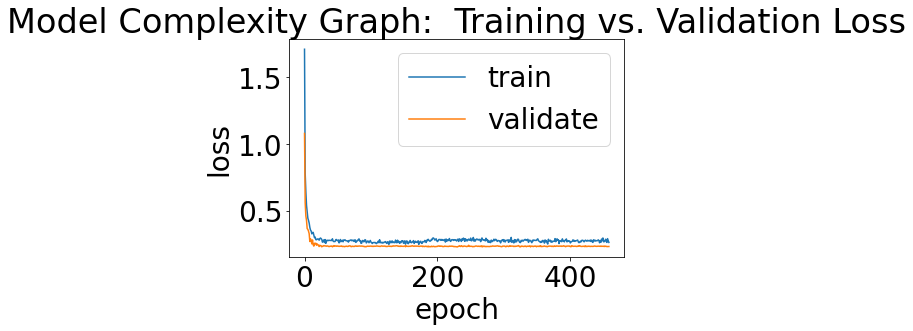

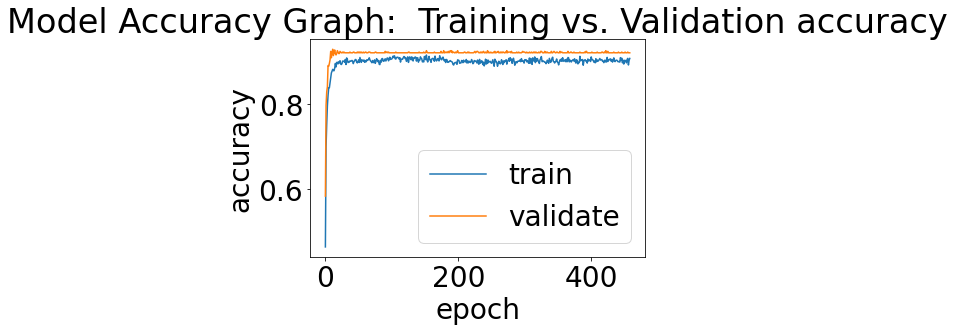

In [ ]:
plt.figure(1)
plt.plot(history1_5['loss'])
plt.plot(history1_5['val_loss'])
plt.title('Model Complexity Graph:  Training vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()
plt.figure(2)
plt.plot(history1_5['accuracy'])
plt.plot(history1_5['val_accuracy'])
plt.title('Model Accuracy Graph:  Training vs. Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')
plt.show()

In [ ]:
score = model_trained.evaluate(mel_test_x, Ytest, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

47/47 [==============================] - 0s 3ms/step - loss: 0.2275 - accuracy: 0.9267
Test loss: 0.22754926979541779
Test accuracy: 0.9266666769981384


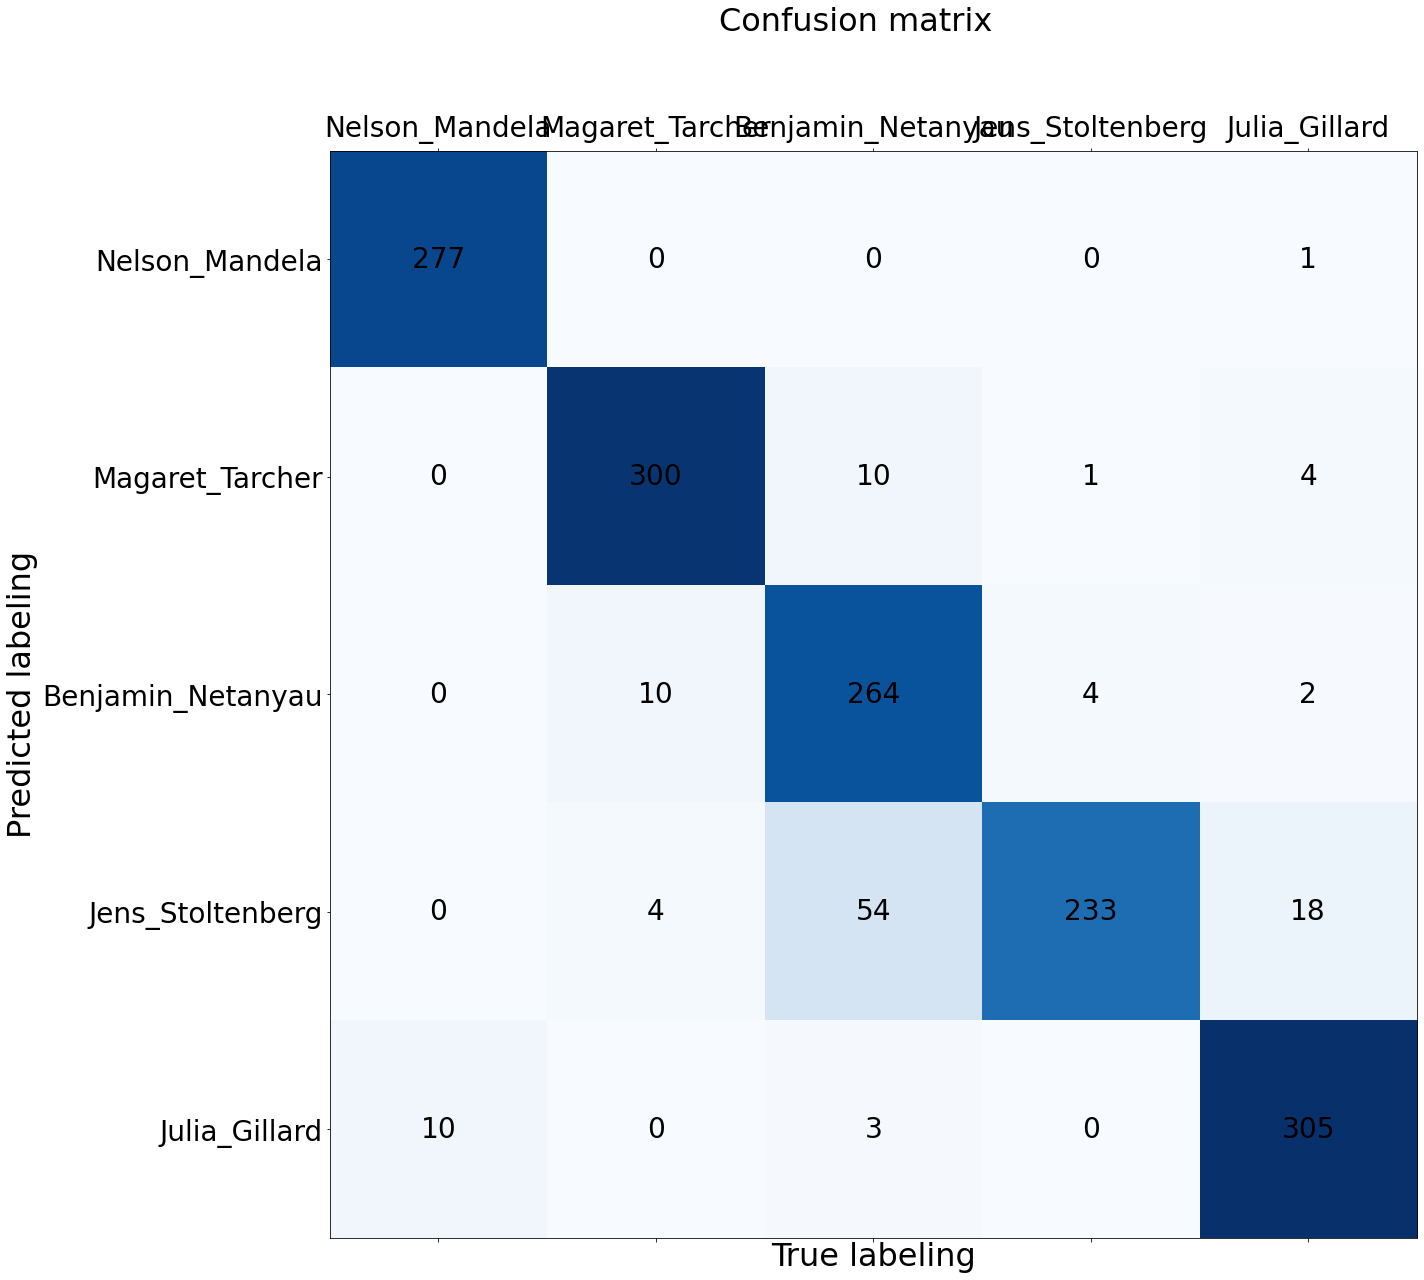

In [ ]:
from sklearn.metrics import confusion_matrix

y_vecs = model_trained.predict(mel_test_x)
y_pred = np.argmax(y_vecs, axis=1)
y_true = Ytest
cm = confusion_matrix(y_true, y_pred)
# print(cm)

# plt.imshow(cm, cmap = 'ocean')
# plt.colorbar

min_val, max_val = 0, 15

# intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(cm, cmap=plt.cm.Blues)
# ax.matshow(cm, cmap=plt.cm.magma_r)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

for i in range(5):
    for j in range(5):
        c = cm[j,i]
        ax.text(i, j, str(c), va='center', ha='center')


plt.xticks(range(5))
plt.yticks(range(5))
plt.suptitle('Confusion matrix',size = 32)
plt.xlabel('True labeling',size = 32)
plt.ylabel('Predicted labeling',size = 32)
plt.rcParams.update({'font.size': 28})

Train with whole Fashion Mnist trained model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/all/saved_model.pb/")
for layer in model.layers[:20]:
   layer.trainable =False

model._layers.pop()
model._layers.pop()
model.summary()

# layer2 = layers.Dense(3, activation="softmax")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0     

In [ ]:
x=model.output
x = Flatten()(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dense(5)(x)
x = Activation("softmax")(x)
inp = model.input
modelall2 =  Model(inputs = inp, outputs =x)
modelall2.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0  

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam ,RMSprop, Adagrad
import os 

Learning_rate = 7.006492321624085e-47

optimizer = Adam(lr=Learning_rate)
 
modelall2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-100)

batch_size = 2400
checkpoint_path = "/content/drive/MyDrive/16000_pcm_speeches/allmodel/"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_accuracy',mode='max',
                                                               save_best_only=True)

In [ ]:
history5 = modelall2.fit(x=mel_train_x, y= Y, epochs = 20, validation_split = 0.10, shuffle = True,
                     batch_size = batch_size, verbose = 1, steps_per_epoch= train_x.shape[0] // batch_size,callbacks=[checkpoint,learning_rate_reduction])
model_trained.save("/content/drive/MyDrive/16000_pcm_speeches/allmodel/") # saving the model

np.save('/content/drive/MyDrive/16000_pcm_speeches/allmodel/history5.npy',history5.history)


Epoch 1/20
2/2 [==============================] - 2s 1s/step - loss: 0.2031 - accuracy: 0.9297 - val_loss: 0.2071 - val_accuracy: 0.9367
INFO:tensorflow:Assets written to: /content/drive/MyDrive/16000_pcm_speeches/allmodel/assets
Epoch 2/20
2/2 [==============================] - 0s 79ms/step - loss: 0.2157 - accuracy: 0.9258 - val_loss: 0.2072 - val_accuracy: 0.9367
Epoch 3/20
2/2 [==============================] - 0s 56ms/step - loss: 0.2065 - accuracy: 0.9300 - val_loss: 0.2072 - val_accuracy: 0.9367
Epoch 4/20
2/2 [==============================] - 0s 77ms/step - loss: 0.2044 - accuracy: 0.9339 - val_loss: 0.2072 - val_accuracy: 0.9367
Epoch 5/20
2/2 [==============================] - 0s 78ms/step - loss: 0.2135 - accuracy: 0.9327 - val_loss: 0.2073 - val_accuracy: 0.9367
Epoch 6/20
2/2 [==============================] - 0s 54ms/step - loss: 0.1993 - accuracy: 0.9323 - val_loss: 0.2072 - val_accuracy: 0.9350
Epoch 7/20
2/2 [==============================] - 0s 78ms/step - loss: 0.20

In [ ]:
history3 = np.load("/content/drive/MyDrive/16000_pcm_speeches/allmodel/history3.npy",allow_pickle=True).item()
history4 = np.load("/content/drive/MyDrive/16000_pcm_speeches/allmodel/history4.npy",allow_pickle=True).item()
history3_4 =  appendHist (history3, history4)
np.save("/content/drive/MyDrive/16000_pcm_speeches/allmodel/history3_4.npy",history3_4)
history3_4 = np.load("/content/drive/MyDrive/16000_pcm_speeches/allmodel/history3_4.npy",allow_pickle=True).item()

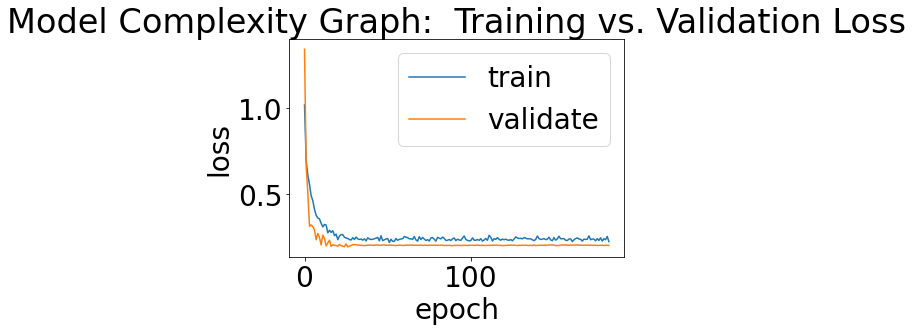

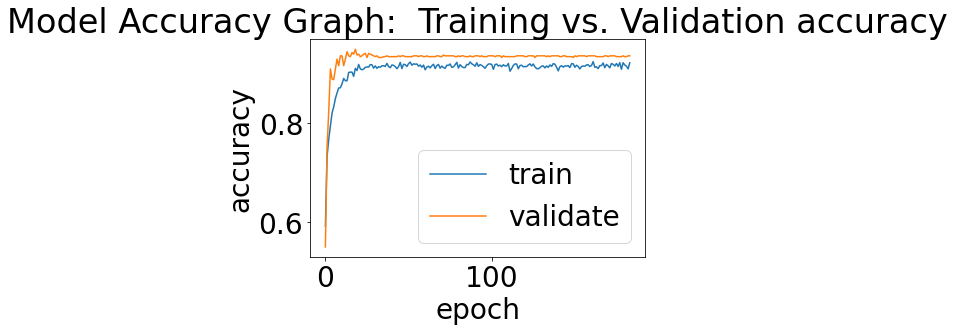

In [ ]:
plt.figure(1)
plt.plot(history3_4['loss'])
plt.plot(history3_4['val_loss'])
plt.title('Model Complexity Graph:  Training vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()
plt.figure(2)
plt.plot(history3_4['accuracy'])
plt.plot(history3_4['val_accuracy'])
plt.title('Model Accuracy Graph:  Training vs. Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')
plt.show()

In [ ]:
score = modelall2.evaluate(mel_test_x, Ytest, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

47/47 [==============================] - 0s 3ms/step - loss: 0.2210 - accuracy: 0.9253
Test loss: 0.22100886702537537
Test accuracy: 0.9253333210945129


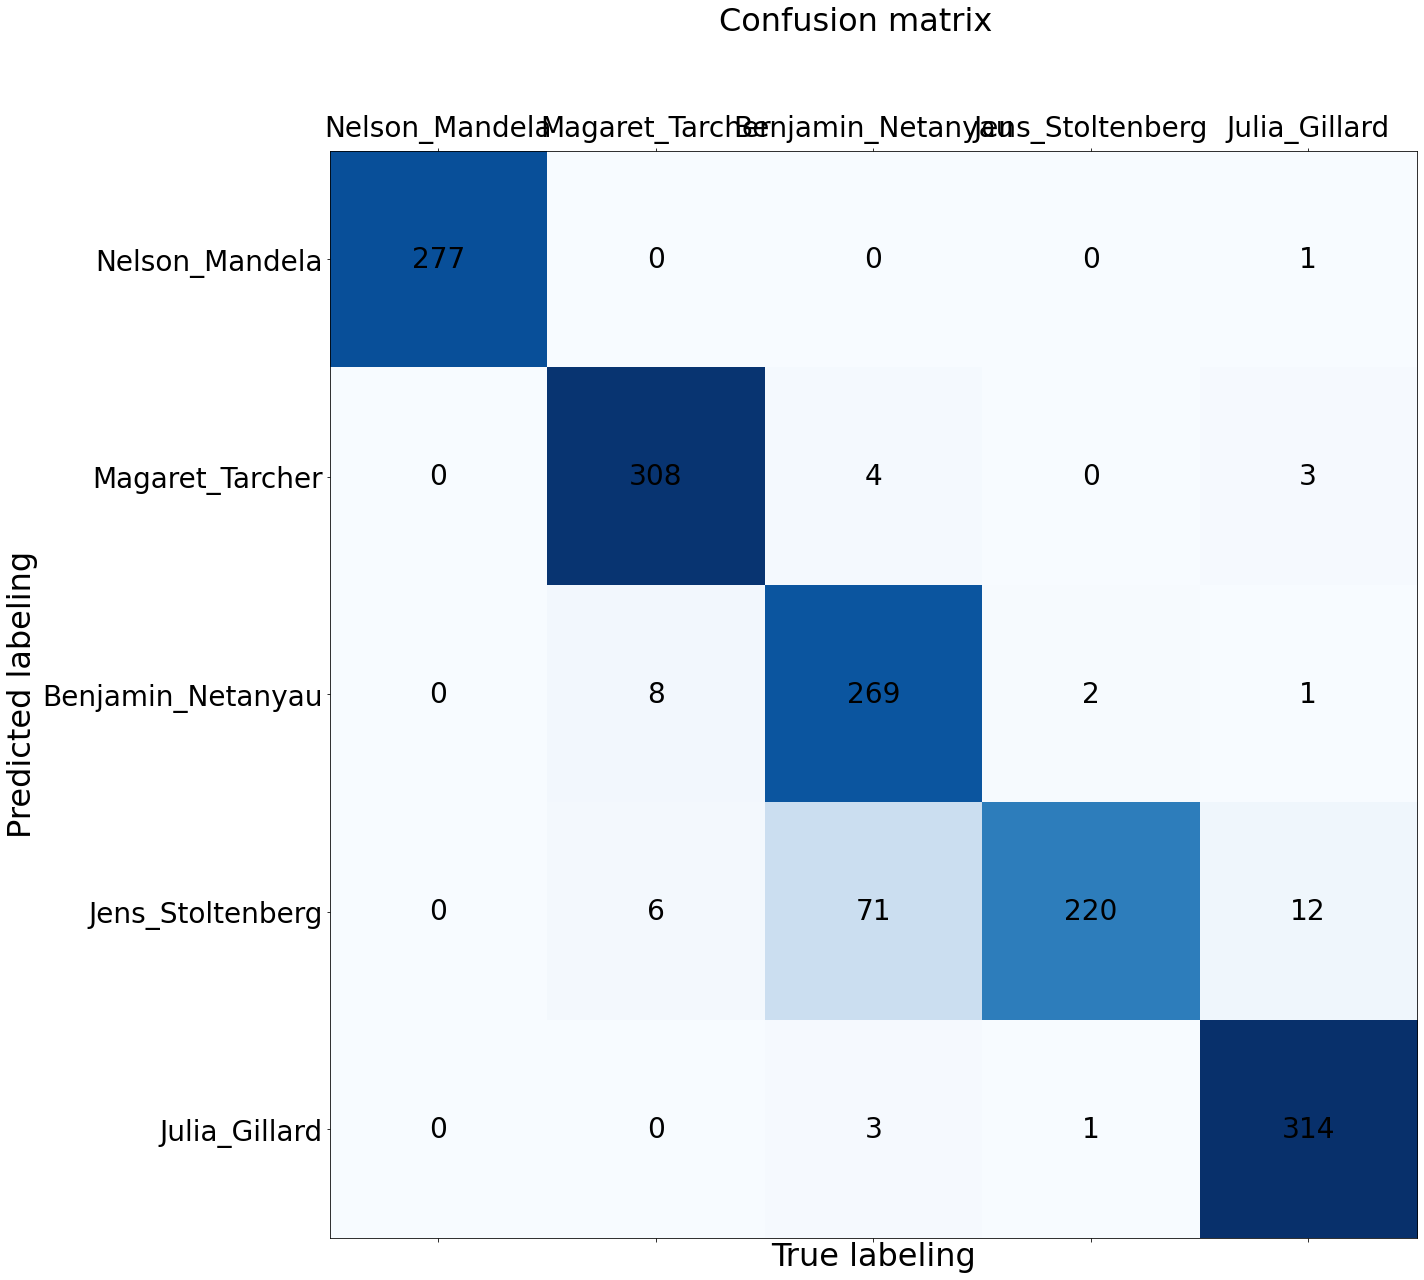

In [ ]:
from sklearn.metrics import confusion_matrix

y_vecs = modelall2.predict(mel_test_x)
y_pred = np.argmax(y_vecs, axis=1)
y_true = Ytest
cm = confusion_matrix(y_true, y_pred)
# print(cm)

# plt.imshow(cm, cmap = 'ocean')
# plt.colorbar

min_val, max_val = 0, 15

# intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(cm, cmap=plt.cm.Blues)
# ax.matshow(cm, cmap=plt.cm.magma_r)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

for i in range(5):
    for j in range(5):
        c = cm[j,i]
        ax.text(i, j, str(c), va='center', ha='center')


plt.xticks(range(5))
plt.yticks(range(5))
plt.suptitle('Confusion matrix',size = 32)
plt.xlabel('True labeling',size = 32)
plt.ylabel('Predicted labeling',size = 32)
plt.rcParams.update({'font.size': 28})

Train with a non trained model

In [ ]:
from tensorflow.python.keras.layers import Input , Dense , Conv2D , Activation , Add,ReLU,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.python.keras.models import Model
input = Input(shape=[28, 28, 1])

x = Conv2D(32, (5, 5), strides=1, padding='same')(input)
x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
x = Activation('relu')(x)

x = Conv2D(32, (5, 5), strides=1, padding='same')(x)
x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
x = Activation('relu')(x)

x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)
x = Dropout (0.35)(x)

x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
x = Activation('relu')(x)

x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)
x = Dropout (0.35)(x)

x = Flatten()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(5)(x)
x = Activation('softmax')(x)

model = Model(inputs = input, outputs =x)

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam ,RMSprop, Adagrad
import os 

Learning_rate = 0.01

optimizer = Adam(lr=Learning_rate)
 
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-100)

batch_size = 64
checkpoint_path = "/content/drive/MyDrive/nontrained"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_accuracy',mode='max',
                                                               save_best_only=True)

In [ ]:
history1 = model.fit(x=mel_train_x, y= Y, epochs = 100, validation_split = 0.10, shuffle = True,
                     batch_size = batch_size, verbose = 1, steps_per_epoch= mel_train_x.shape[0] // batch_size,callbacks=[checkpoint,learning_rate_reduction])
model.save("/content/drive/MyDrive/nontrained") # saving the model

np.save('/content/drive/MyDrive/nontrained/history1.npy',history1.history)

Epoch 1/100
93/93 [==============================] - 2s 10ms/step - loss: 0.9636 - accuracy: 0.6733 - val_loss: 0.5823 - val_accuracy: 0.8383
INFO:tensorflow:Assets written to: /content/drive/MyDrive/16000_pcm_speeches/allmodel/assets
Epoch 2/100
93/93 [==============================] - 1s 8ms/step - loss: 0.2079 - accuracy: 0.9198 - val_loss: 0.2770 - val_accuracy: 0.9167
INFO:tensorflow:Assets written to: /content/drive/MyDrive/16000_pcm_speeches/allmodel/assets
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 0.0783 - accuracy: 0.9731 - val_loss: 0.0798 - val_accuracy: 0.9717
INFO:tensorflow:Assets written to: /content/drive/MyDrive/16000_pcm_speeches/allmodel/assets
Epoch 4/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0934 - accuracy: 0.9644 - val_loss: 0.1297 - val_accuracy: 0.9533
Epoch 5/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0405 - accuracy: 0.9842 - val_loss: 0.1180 - val_accuracy: 0.9700
Epoch 6/100
93/

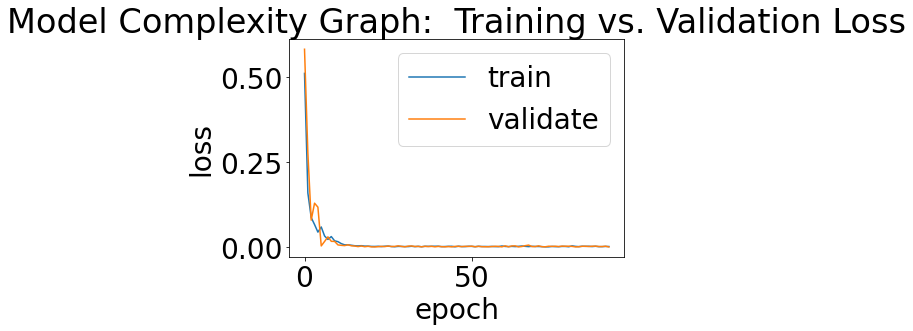

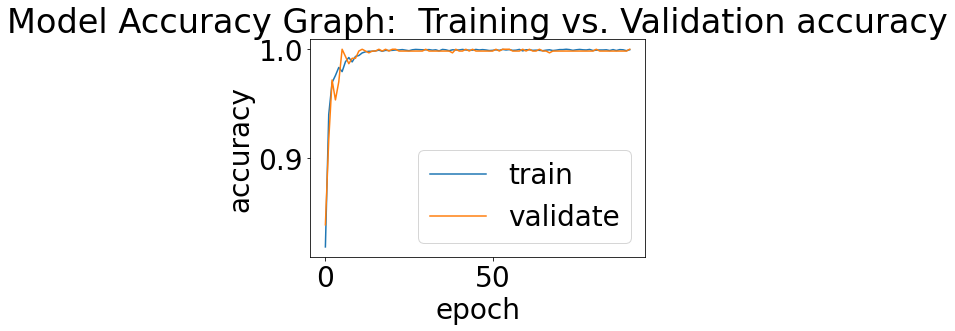

In [ ]:

plt.figure(1)
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('Model Complexity Graph:  Training vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()
plt.figure(2)
plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.title('Model Accuracy Graph:  Training vs. Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')
plt.show()

In [ ]:
history1 = np.load('/content/drive/MyDrive/nontrained/history1.npy',allow_pickle=True).item()

In [ ]:
score = model.evaluate(mel_test_x, Ytest, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

47/47 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.9980
Test loss: 0.0030571813695132732
Test accuracy: 0.9980000257492065


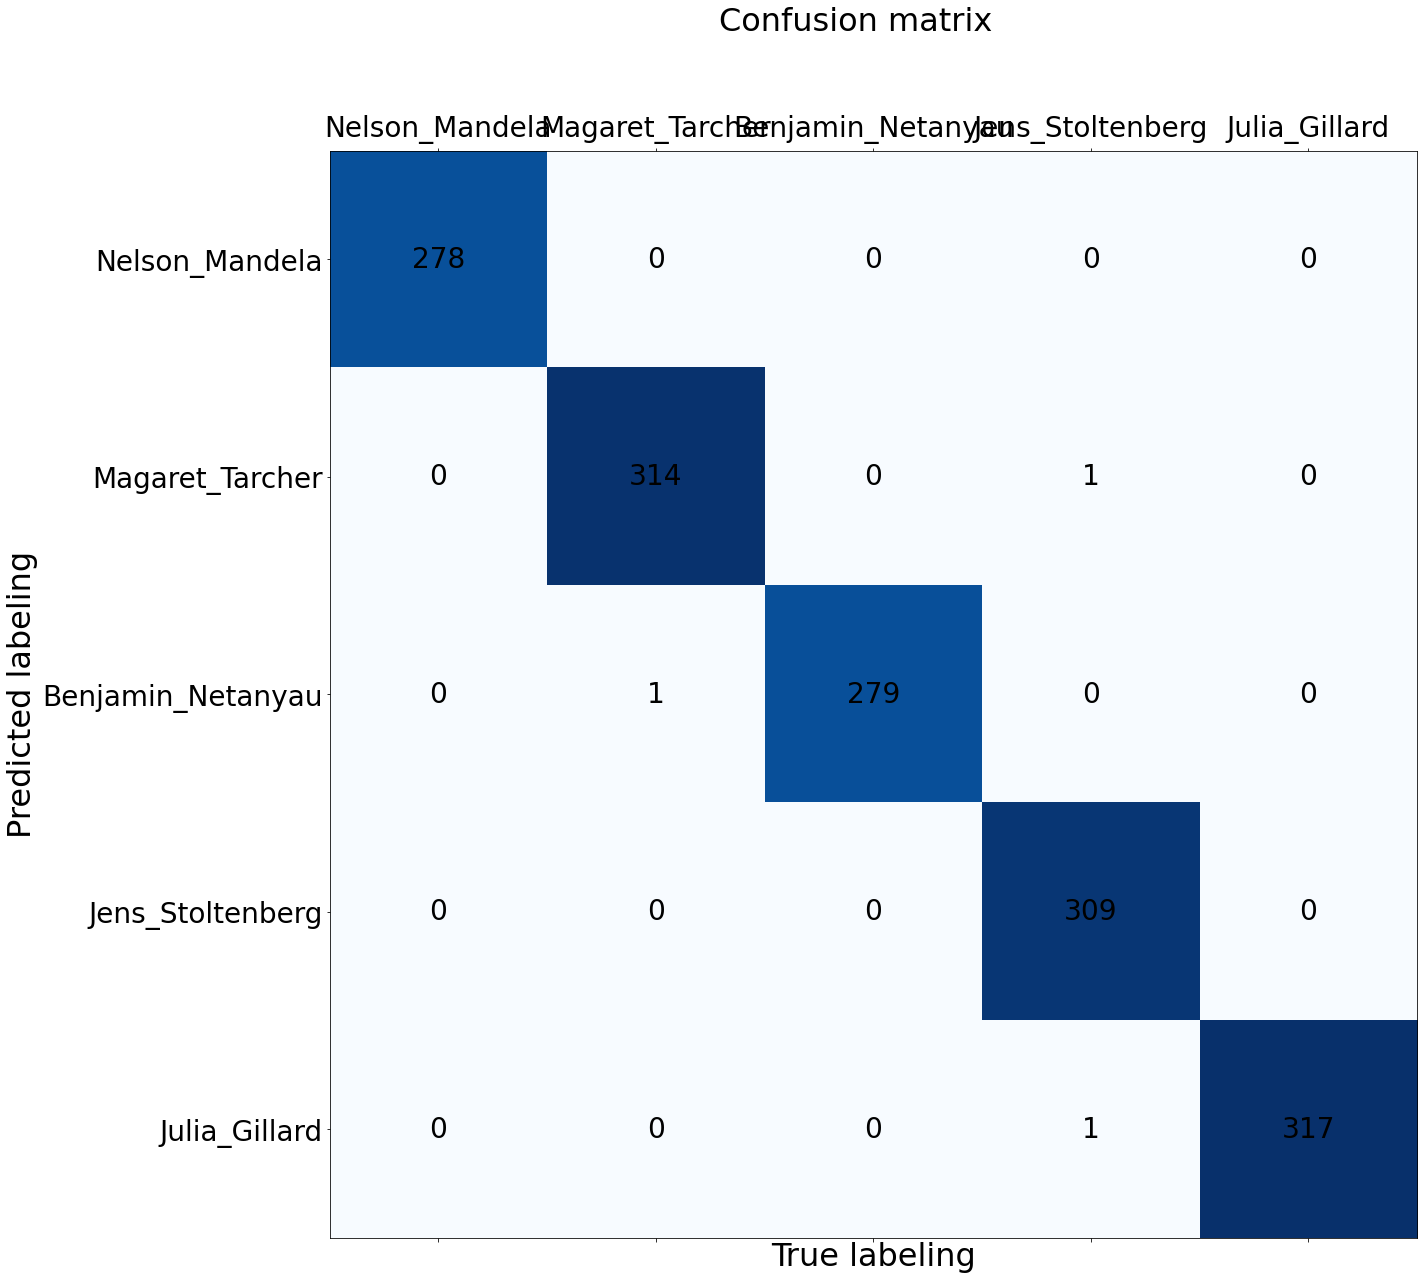

In [ ]:
from sklearn.metrics import confusion_matrix

y_vecs = model.predict(mel_test_x)
y_pred = np.argmax(y_vecs, axis=1)
y_true = Ytest
cm = confusion_matrix(y_true, y_pred)
# print(cm)

# plt.imshow(cm, cmap = 'ocean')
# plt.colorbar

min_val, max_val = 0, 15

# intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(cm, cmap=plt.cm.Blues)
# ax.matshow(cm, cmap=plt.cm.magma_r)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

for i in range(5):
    for j in range(5):
        c = cm[j,i]
        ax.text(i, j, str(c), va='center', ha='center')


plt.xticks(range(5))
plt.yticks(range(5))
plt.suptitle('Confusion matrix',size = 32)
plt.xlabel('True labeling',size = 32)
plt.ylabel('Predicted labeling',size = 32)
plt.rcParams.update({'font.size': 28})